In [3]:
import time
import json

# Third-party
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import requests

from gary.observation import distance
import gary.coordinates as gc

import pandas as pd

In [4]:
def dust_query(lon, lat, coordsys='gal', mode='full'):
    '''
    Send a line-of-sight reddening query to the Argonaut web server.
    
    Inputs:
      lon, lat: longitude and latitude, in degrees.
      coordsys: 'gal' for Galactic, 'equ' for Equatorial (J2000).
      mode: 'full', 'lite' or 'sfd'
    
    In 'full' mode, outputs a dictionary containing, among other things:
      'distmod':    The distance moduli that define the distance bins.
      'best':       The best-fit (maximum proability density)
                    line-of-sight reddening, in units of SFD-equivalent
                    E(B-V), to each distance modulus in 'distmod.' See
                    Schlafly & Finkbeiner (2011) for a definition of the
                    reddening vector (use R_V = 3.1).
      'samples':    Samples of the line-of-sight reddening, drawn from
                    the probability density on reddening profiles.
      'success':    1 if the query succeeded, and 0 otherwise.
      'converged':  1 if the line-of-sight reddening fit converged, and
                    0 otherwise.
      'n_stars':    # of stars used to fit the line-of-sight reddening.
      'DM_reliable_min':  Minimum reliable distance modulus in pixel.
      'DM_reliable_max':  Maximum reliable distance modulus in pixel.
    
    Less information is returned in 'lite' mode, while in 'sfd' mode,
    the Schlegel, Finkbeiner & Davis (1998) E(B-V) is returned.
    '''
    
    url = 'http://argonaut.skymaps.info/gal-lb-query-light'
    
    payload = {'mode': mode}
    
    if coordsys.lower() in ['gal', 'g']:
        payload['l'] = lon
        payload['b'] = lat
    elif coordsys.lower() in ['equ', 'e']:
        payload['ra'] = lon
        payload['dec'] = lat
    else:
        raise ValueError("coordsys '{0}' not understood.".format(coordsys))
    
    headers = {'content-type': 'application/json'}
    
    r = requests.post(url, data=json.dumps(payload), headers=headers)
    
    try:
        r.raise_for_status()
    except requests.exceptions.HTTPError as e:
        print('Response received from Argonaut:')
        print(r.text)
        raise e
    
    return json.loads(r.text)

In [5]:
field = 10

In [6]:
d = pd.read_csv("../data/field{0}.csv".format(field), delimiter="|") #, header=None)

In [7]:
print(len(d))
print(d.columns)

543737
Index([u'ID', u'HIP', u'TYC', u'UCAC', u'2MASS', u'SDSS', u'Objtype', u'Kepflag', u'StpropFlag', u'RA', u'DEC', u'pmRA', u'e_pmRA', u'pmDEC', u'e_pmDEC', u'plx', u'e_plx', u'Bmag', u'e_Bmag', u'Vmag', u'e_Vmag', u'umag', u'e_umag', u'gmag', u'e_gmag', u'rmag', u'e_rmag', u'imag', u'e_imag', u'zmag', u'e_zmag', u'Jmag', u'e_Jmag', u'Hmag', u'e_Hmag', u'Kmag', u'e_Kmag', u'W1mag', u'e_W1mag', u'W2mag', u'e_W2mag', u'W3mag', u'e_W3mag', u'W4mag', u'e_W4mag', u'Kp', u'Teff', u'e_Teff', u'logg', u'e_logg', u'[Fe/H]', u'e_[Fe/H]', u'Rad', u'e_Rad', u'Mass', u'e_Mass', u'rho', u'e_rho', u'Lum', u'e_Lum', u'd', u'e_d', u'E(B-V)', u'NOMAD', u'Mflg', u'prox'], dtype='object')


## Stars

In [8]:
ix = (d['Objtype'] == 'STAR')
stars = d[ix]

## Footprint

(187.713605, -2.8715669999999998)
8.9176705


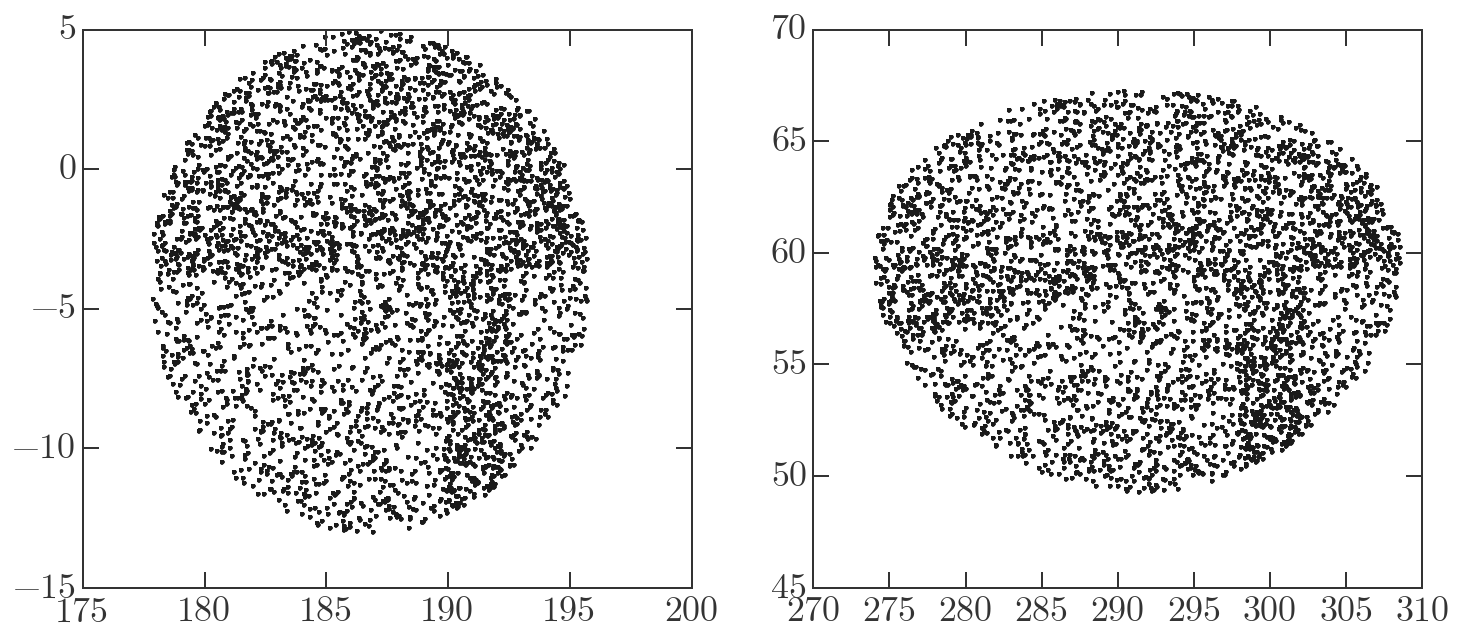

In [9]:
_fpt = stars.iloc[::100]

cc = coord.SkyCoord(ra=np.array(_fpt.RA)*u.degree,
                    dec=np.array(_fpt.DEC)*u.degree)

fig,axes = plt.subplots(1,2,figsize=(12,5))
axes[0].plot(_fpt.RA, _fpt.DEC, ls='none')
axes[1].plot(cc.galactic.l.degree, cc.galactic.b.degree, ls='none')

print(np.median(_fpt.RA), np.median(_fpt.DEC))
print((np.max(_fpt.RA) - np.min(_fpt.RA))/2.)

## Check extinction

In [10]:
_test_star = stars.ix[1024]
c = coord.SkyCoord(ra=_test_star.RA*u.degree, dec=_test_star.DEC*u.degree)
_test_dust = dust_query(lon=c.galactic.l.degree, lat=c.galactic.b.degree, mode='lite')

In [11]:
print(c.ra.degree, c.dec.degree)
print(c.galactic.l.degree, c.galactic.b.degree)

(187.374186, -12.737225)
(294.6297229516648, 49.780502456166566)


## Get all extinction values

In [12]:
c = coord.SkyCoord(ra=stars.RA*u.degree, dec=stars.DEC*u.degree)
gal_c = c.galactic

In [13]:
# # Query for extinction
# # BRUTAL
# E_BmV = []
# for left in range(0,len(stars)+1,50000):
#     dust = dust_query(lon=gal_c.l.degree[left:left+50000].tolist(), 
#                       lat=gal_c.b.degree[left:left+50000].tolist(), 
#                       mode='lite')
#     E_BmV.append(np.array(dust['best'])[:,-1])
#     time.sleep(1)

In [22]:
# np.save("../data/E_BmV_{0}.npy".format(field), np.concatenate(E_BmV))

In [23]:
E_BmV = np.load("../data/E_BmV_{0}.npy".format(field))

In [28]:
stars['E(B-V)'] = E_BmV

/Users/adrian/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  if __name__ == '__main__':


## Correct all magnitudes

In [29]:
Av_factors = {
    'umag': 4.239,
    'gmag': 3.303,
    'rmag': 2.285,
    'Jmag': 0.723,
    'Hmag': 0.460, 
    'Kmag': 0.310
}

for k,v in Av_factors.items():
    stars["{0}0".format(k)] = stars[k] - stars['E(B-V)'] * v

/Users/adrian/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


## Stars with 2MASS photometry

In [31]:
ix = np.isfinite(stars['Jmag0']) & np.isfinite(stars['Hmag0']) & np.isfinite(stars['Kmag0']) & (stars['Kmag0'] < 14.)
stars_2mass = stars[ix]
len(stars_2mass)

105081

## Correct colors

via Majewski et al. (2003), Eq. 1

In [32]:
J_K = (stars_2mass['Jmag0'] - stars_2mass['Kmag0'])
J_H = (stars_2mass['Jmag0'] - stars_2mass['Hmag0'])
K = stars_2mass['Kmag0']

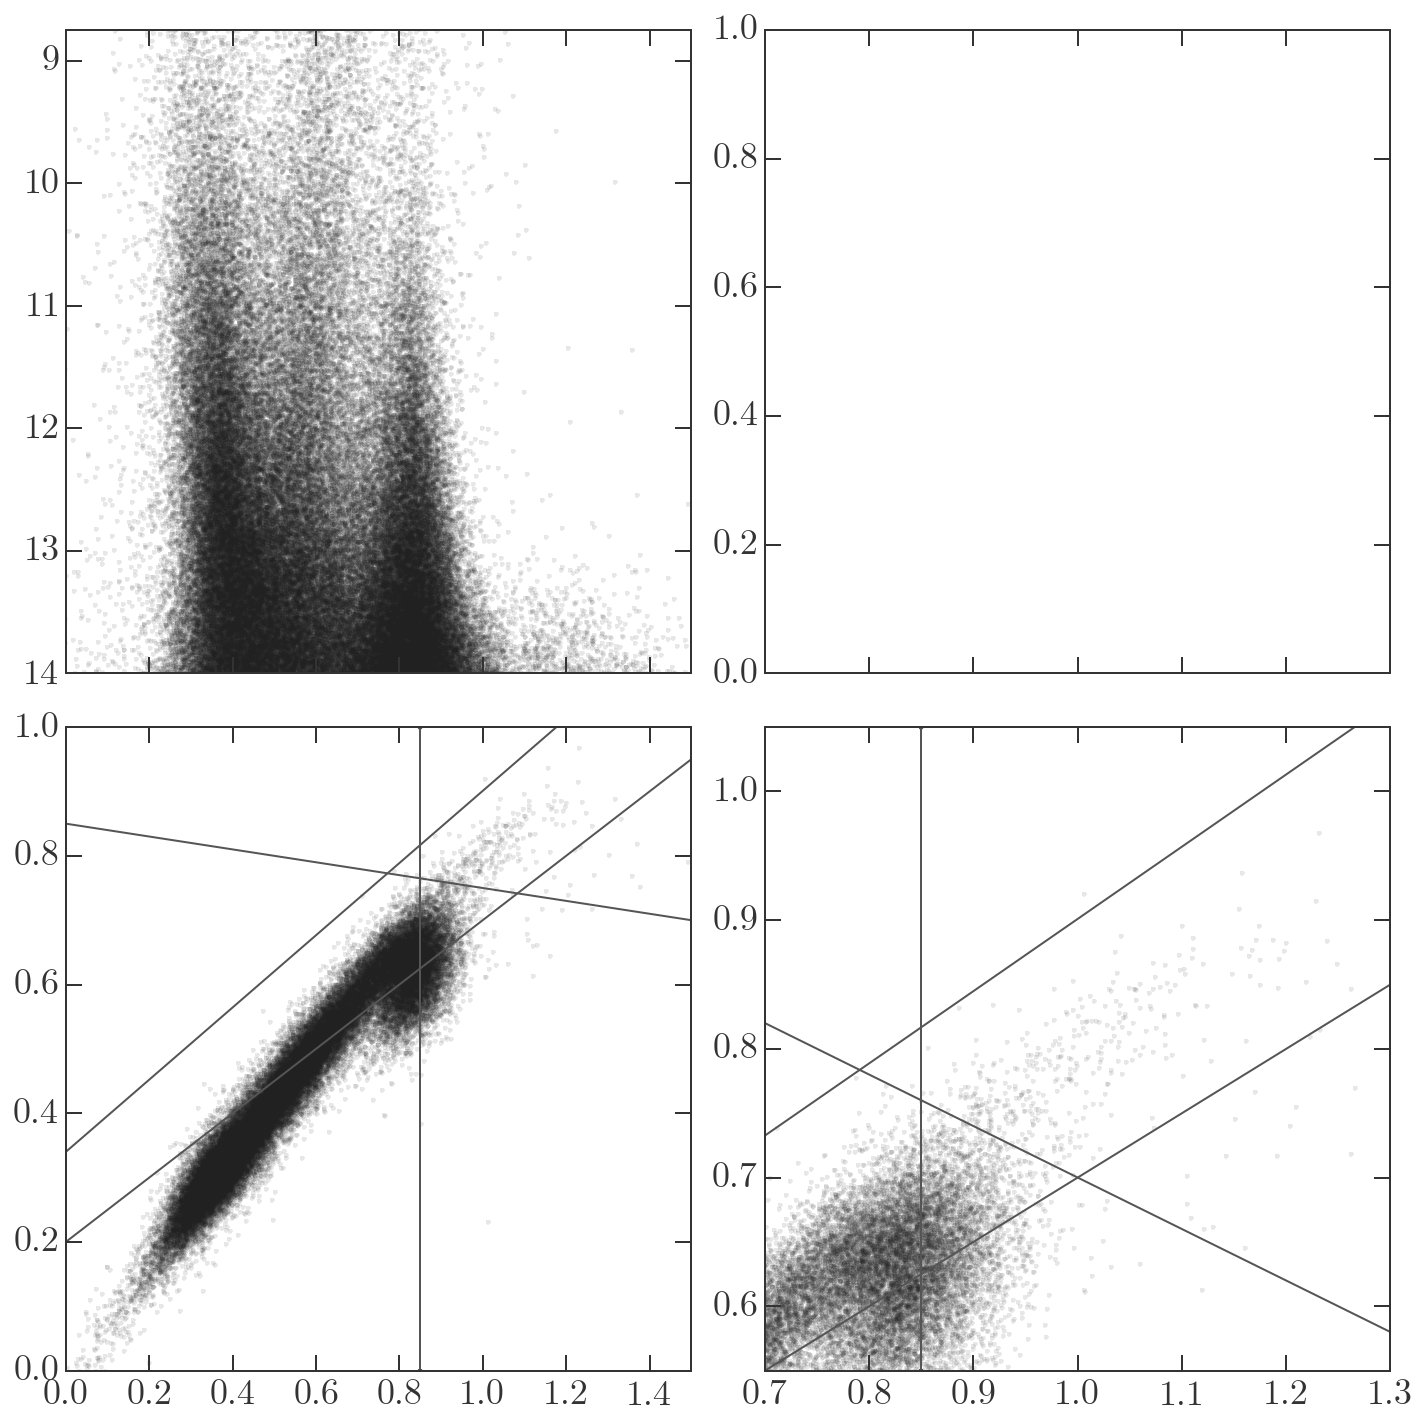

In [33]:
fig,axes = plt.subplots(2,2,figsize=(10,10), sharex='col')

ax = axes[0,0]
ax.plot(J_K, K, linestyle='none', marker='.', alpha=0.1)
ax.set_ylim(14., 8.75)

# ax = axes[0,1]

ax = axes[1,0]
ax.plot(J_K[K < 13.1], J_H[K < 13.1], linestyle='none', marker='.', alpha=0.1)

ax.set_xlim(0., 1.5)
ax.set_ylim(0., 1.)

x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
ax.plot(x, 0.561*x + 0.34, marker=None, c='#555555')
ax.plot(x, 0.5*x + 0.2, marker=None, c='#555555')
ax.plot(x, -0.1*x + 0.85, marker=None, c='#555555')
ax.axvline(0.85, c='#555555')

ax = axes[1,1]
ax.plot(J_K[K < 13.1], J_H[K < 13.1], linestyle='none', marker='.', alpha=0.1)

ax.set_xlim(0.7, 1.3)
ax.set_ylim(.55, 1.05)

x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
ax.plot(x, 0.561*x + 0.34, marker=None, c='#555555')
ax.plot(x, 0.5*x + 0.2, marker=None, c='#555555')
ax.plot(x, -0.4*x + 1.1, marker=None, c='#555555')
ax.axvline(0.85, c='#555555')

fig.tight_layout()

## Color selection

In [34]:
pm_cut = (np.isnan(stars_2mass['pmRA']) | 
          ((np.abs(stars_2mass['pmRA']) < 10.) & (np.abs(stars_2mass['pmDEC']) < 10.)))

box_ix = ((J_H < (0.561*J_K + 0.34)) & 
          (J_H > (0.5*J_K + 0.2)) & 
          (J_H > (-0.4*J_K + 1.1)) & 
          (J_K > 0.85) & (J_K < 1.1) & 
          (K < 13.) & (K > 10.) & pm_cut)

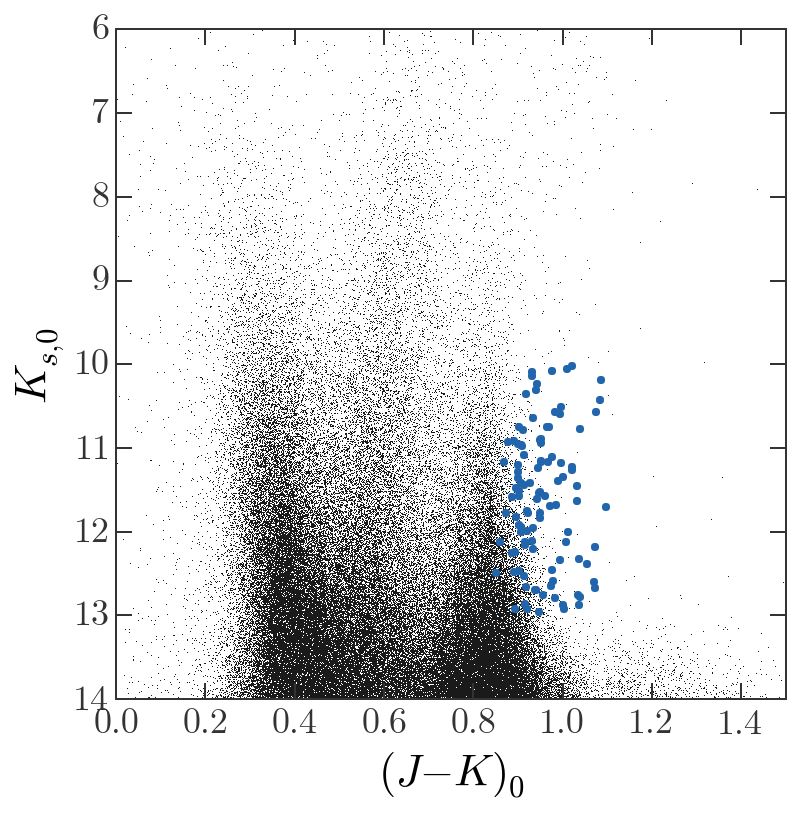

In [46]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(J_K, K, linestyle='none', marker=',', alpha=1.)
ax.plot(J_K[box_ix], K[box_ix], linestyle='none', marker='.', alpha=1, ms=8)

ax.set_xlim(0., 1.5)
ax.set_ylim(14., 6)

ax.set_xlabel("$(J-K)_0$")
ax.set_ylabel("$K_{s,0}$")

In [47]:
targets = stars_2mass[box_ix]
len(targets)

107

In [48]:
target_coords = coord.SkyCoord(ra=targets['RA']*u.degree,
                               dec=targets['DEC']*u.degree)
target_sgr = target_coords.transform_to(gc.Sagittarius)

In [49]:
# crude distance estimate
MK = -8.93*J_K + 3.483
dm = K - MK
dist = distance(np.array(dm[box_ix]))

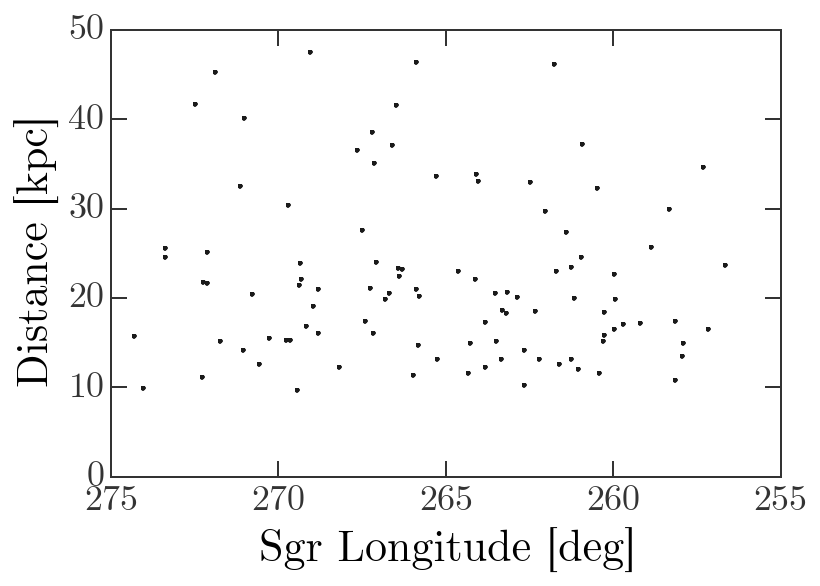

In [51]:
plt.plot(target_sgr.Lambda.degree, dist.to(u.kpc).value, linestyle='none')
plt.ylim(0,50)
plt.xlim(275, 255)
plt.xlabel('Sgr Longitude [deg]')
plt.ylabel('Distance [kpc]')

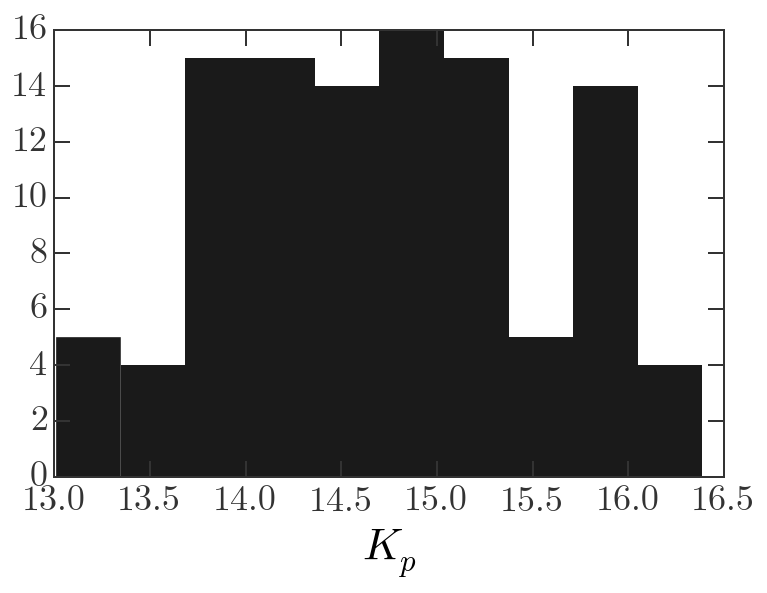

In [40]:
plt.hist(np.array(targets['Kp']));
plt.xlabel("$K_p$")

# 107 M giants

---

Stuff...

In [41]:
# only keep stars with proper motions
good_pm_ix = np.isfinite(stars.pmRA) & np.isfinite(stars.pmDEC)
pm_stars = stars[good_pm_ix]

# remove dwarfs the easy way
low_pm_stars = pm_stars[(np.abs(pm_stars.pmRA) < 6) & (np.abs(pm_stars.pmDEC) < 6)]

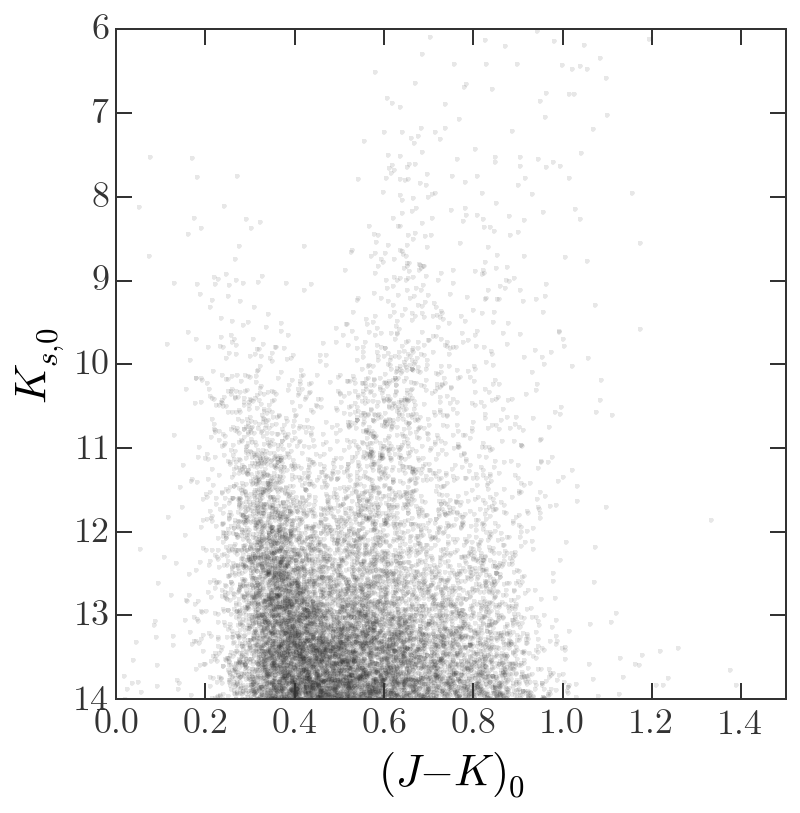

In [42]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
plt.plot(low_pm_stars['Jmag0'] - low_pm_stars['Kmag0'], 
         low_pm_stars['Kmag0'], ls='none', marker='.', alpha=0.1)

ax.set_xlim(0., 1.5)
ax.set_ylim(14., 6)

ax.set_xlabel("$(J-K)_0$")
ax.set_ylabel("$K_{s,0}$")

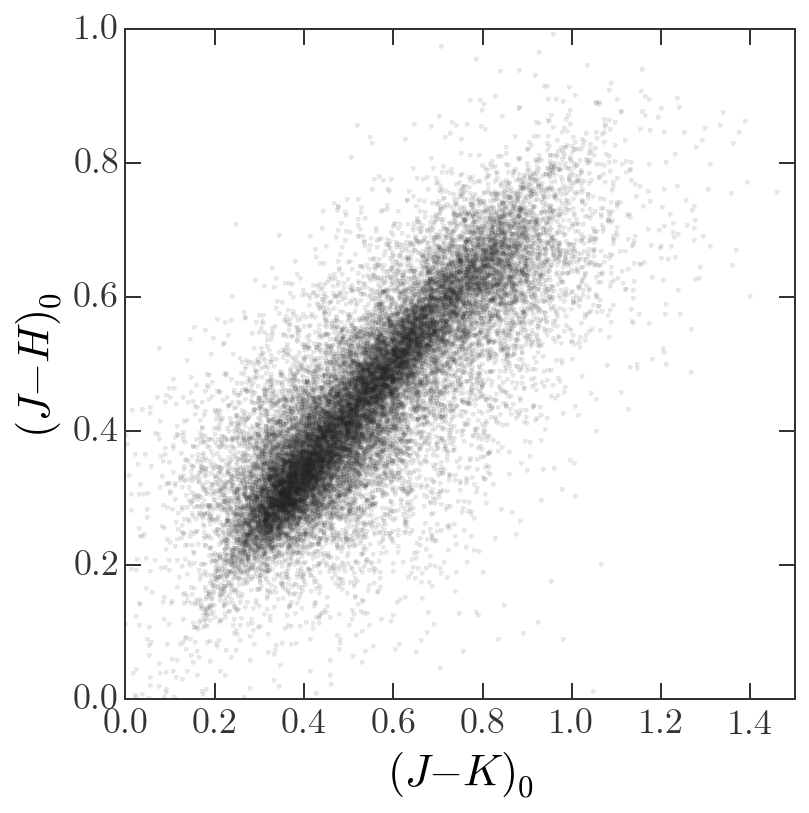

In [43]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
plt.plot(low_pm_stars['Jmag0'] - low_pm_stars['Kmag0'], 
         low_pm_stars['Jmag0'] - low_pm_stars['Hmag0'], 
         ls='none', marker='.', alpha=0.1)

ax.set_xlim(0., 1.5)
ax.set_ylim(0, 1)

ax.set_xlabel("$(J-K)_0$")
ax.set_ylabel("$(J-H)_0$")

In [44]:
_ix = (((low_pm_stars['Jmag0'] - low_pm_stars['Kmag0']) > 0.6) & 
       ((low_pm_stars['Jmag0'] - low_pm_stars['Kmag0']) < 0.85))
maybe_kgiants = low_pm_stars[_ix]

KG_coords = coord.SkyCoord(ra=maybe_kgiants['RA']*u.degree,
                           dec=maybe_kgiants['DEC']*u.degree)
KG_sgr = KG_coords.transform_to(gc.Sagittarius)

maybe_kgiants = maybe_kgiants[np.abs(KG_sgr.Beta.degree) < 15.]
KG_coords = coord.SkyCoord(ra=maybe_kgiants['RA']*u.degree,
                           dec=maybe_kgiants['DEC']*u.degree)
KG_sgr = KG_coords.transform_to(gc.Sagittarius)

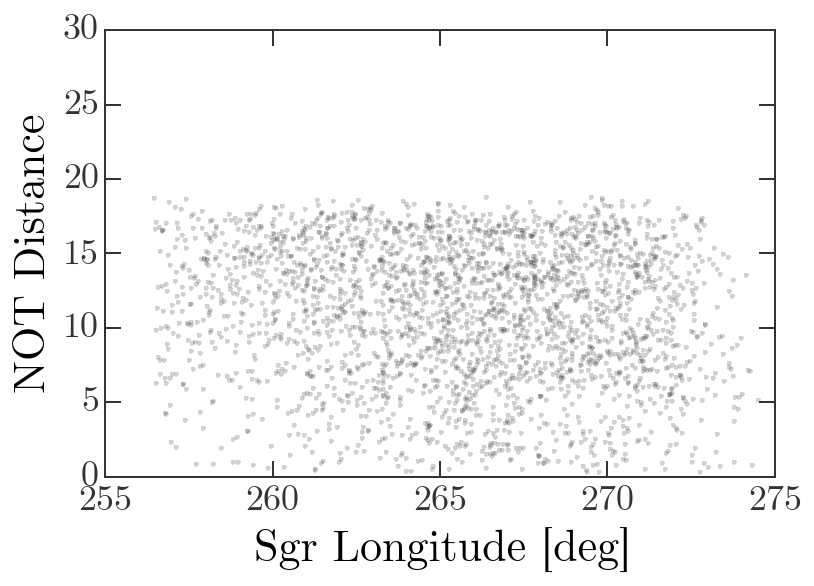

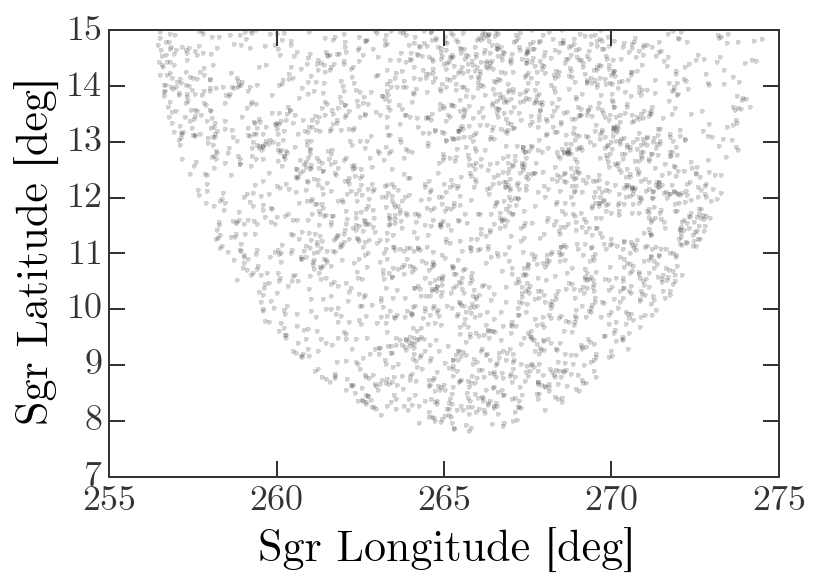

In [45]:
KG_dist_proxy = distance(np.array(maybe_kgiants['Kmag0']) + 1)

plt.figure()
plt.plot(KG_sgr.Lambda.degree, KG_dist_proxy.to(u.kpc).value, linestyle='none', alpha=0.2)
plt.ylim(0,30)
plt.xlabel('Sgr Longitude [deg]')
plt.ylabel('NOT Distance')

plt.figure()
plt.plot(KG_sgr.Lambda.degree, KG_sgr.Beta.degree, linestyle='none', alpha=0.2)
# plt.ylim(0,30)
plt.xlabel('Sgr Longitude [deg]')
plt.ylabel('Sgr Latitude [deg]')